# WeRateDogs Twitter Feed

This project looks at various data sources for Tweets from the [WeRateDogs](https://twitter.com/dog_rates) Twitter account, specifically:

1. the `twitter-archive-enhanced.csv` which contains the tweet text, as is the core data set
1. the Twitter API is used to access the original tweets to retrieve missing fields such as the retweet and favorite counts
1. an image prediction file containing the top 3 predictions for each of the (up to 4) dog pictures in the tweet

Having gathered the data, we assess, clean and analyse it.


---
---

## Gather

We use a number of data assets including remote files on web servers, and JSON payloads returned by the Twitter API.

In [1]:
WE_RATE_DOGS_TWEETS_PATH = 'data/twitter-archive-enhanced.csv'
DOG_BREED_PREDICTIONS_SOURCE_URL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

### Gather the enhanced Tweets data

Pandas `read_csv()` function is quite versatile when uploading data, and can be configured to handle different date formats, numeric data types, not available (NA) markers, etc. Getting this right upfront can save time, but requires the raw data in files to be eyeballed first. For this we can use command line tools like head & tail, or alternatively Excel, which allows column headings to be frozen, data to be sorted and searched, etc.

Having looked at the raw data, we make the following observations:

1. tweet Ids are large integers, we need to select an approriate integer datatype so no accuracy is lost
1. some tweet Ids use floats, e.g.: `in_reply_to_status_id`, `in_reply_to_user_id`, with NaNs used as a Not Available marker, as mentioned above these need to be converted to integers
1. time stamps are close to ISO 8601 format, and are GMT

Actions taken to address above observations:

* convert floating point tweets Ids to a 64-bit integer, retaining the Not Available representation
* specifcally tell Pandas which columns are dates

In [2]:
import yaml
import tweepy
import json

In [3]:
import numpy as np
import pandas as pd

Load the enhanced Twitter archive, using explicit data types for fields, instead of letting Pandas infer them. The [Twitter API](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/tweet-object) will define the data types for the Twitter sourced fields.

To get around the fact that nullable numeric fields are interpreted by `read_csv()` as floats (thus allowing NaNs to represent null), we will map nullable tweet Ids to the Pandas nullable integer data type (Int64).

In [4]:
feed_data_types = {
    'tweet_id': np.int64,
    'in_reply_to_status_id': 'Int64',
    'in_reply_to_user_id': 'Int64',
    'retweeted_status_id': 'Int64',
    'retweeted_status_user_id': 'Int64',
    'text': 'string',
    'expanded_urls': 'string',
    'rating_numerator': np.int32,
    'rating_denominator': np.int32,
    'name': 'string',
    'doggo': 'string',
    'floofer': 'string',
    'pupper': 'string',
    'puppo': 'string'
}

feed_date_cols = [
    'timestamp', 
    'retweeted_status_timestamp'
]

In [5]:
enhanced_tweets_df = pd.read_csv(WE_RATE_DOGS_TWEETS_PATH,
                        index_col=['tweet_id'],
                        dtype=feed_data_types,
                        parse_dates=feed_date_cols)
enhanced_tweets_df.shape

(2356, 16)

The first discrepancy we note is that, according to the project motivation document, the main "archive contains basic tweet data for all 5000+ of their tweets" however that is clearly not the case as, having loaded it, the number of tweets is less than half that. As this is the master data set we have been provided with, this is the data we have to go with, since it has been previously enhanced.

To sanity check this row count, and make sure we have actually read in all the eprovided data, we will run a line count on the input file, which should roughly match the number of rows in the data frame. Any discrepancy on counts is due to those embeded new line (NL) characters in the tweet text, since the number of NL characters is what `wc` bases its line counts on.

In [6]:
!wc -l {WE_RATE_DOGS_TWEETS_PATH}

2518 data/twitter-archive-enhanced.csv


Now we can double check the column data types, against the data type mapping provided to `read_csv()`.

In [7]:
enhanced_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   in_reply_to_status_id       78 non-null     Int64              
 1   in_reply_to_user_id         78 non-null     Int64              
 2   timestamp                   2356 non-null   datetime64[ns, UTC]
 3   source                      2356 non-null   object             
 4   text                        2356 non-null   string             
 5   retweeted_status_id         181 non-null    Int64              
 6   retweeted_status_user_id    181 non-null    Int64              
 7   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 8   expanded_urls               2297 non-null   string             
 9   rating_numerator            2356 non-null   int32              
 10  rating_denominator          2

### Gather the Twitter API enrichment data

Next we want to use the Twitter API to retrieve the original tweets, so that we can enrich our enhanced tweets data with the missing attributes previously idientified (`retweet_counts`, `favorite_counts`).

Having registered with Twitter as a developer, and obtained credentials and keys, we stored these in a private project directory and configuration file (which are excluded from our git repo, and thus won't be visible online in [github](https://github.com/benvens-udacity/wrangle-and-analyze-data/blob/main/wrangle_act.ipynb)).

We now use those credentials to authenticate with Twitter for API access.

In [8]:
def read_creds(conf_path):
    with open(conf_path, 'r') as cf:
        config = yaml.load(cf, Loader=yaml.FullLoader)
        return config

In [9]:
creds = read_creds('./config/private/creds.yaml')

In [10]:
consumer_key = creds['consumer_api']['key']
consumer_secret = creds['consumer_api']['secret']

In [11]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)

In [12]:
access_token = creds['access_token']['token']
acess_secret = creds['access_token']['secret']

In [13]:
auth.set_access_token(access_token, acess_secret)

Next we will load the enrichment data in batches, for better performance, as API invocations are subject to significant network latency. Twitter also applies rate limiting to their APIs, so it is necessary to throttle the rate at which we make requests, and to retry any failed requests. Luckily, this can be handled automatically by the Tweepy library, by setting the `wait_on_rate_limit_notify` flag when configuring API connection.

In [14]:
api = tweepy.API(auth, wait_on_rate_limit_notify=True)

In [15]:
def process_batch(batch):
    idxs = []
    retweet_counts = []
    favorite_counts = []
    for status in batch:
        tweet = status._json
        idxs.append(tweet['id'])
        retweet_counts.append(tweet['retweet_count'])
        favorite_counts.append(tweet['favorite_count'])
    return np.array(idxs, dtype=np.int64), np.array([retweet_counts, favorite_counts], dtype=np.int64).T

In [16]:
indices = np.empty((0), dtype=np.int64)
rows = np.empty((0, 2), dtype=np.int64)

In [17]:
batch_size = 100
num_tweets = len(enhanced_tweets_df.index)

In [18]:
%%time 
for batch_start in range(0, num_tweets, batch_size):
    batch_end = min(batch_start + batch_size, num_tweets)
    batch_tweet_ids = enhanced_tweets_df.iloc[batch_start:batch_end].index.to_numpy().tolist()
    statuses = api.statuses_lookup(batch_tweet_ids, include_entities=False, map_=False)
    b_indices, b_rows = process_batch(statuses)
    indices = np.concatenate((indices, b_indices), axis=0)
    rows = np.concatenate((rows, b_rows), axis=0)

CPU times: user 2 s, sys: 131 ms, total: 2.13 s
Wall time: 10.9 s


In [19]:
tweet_counts_df = pd.DataFrame(index=indices, data=rows, 
                               columns=['retweet_counts', 'favorite_counts'], 
                               dtype='Int32').sort_index()
tweet_counts_df.index.name = 'tweet_id'
tweet_counts_df.shape

(2331, 2)

Again, we briefly double check on the expected column data type mapping.

In [20]:
tweet_counts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 666020888022790149 to 892420643555336193
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   retweet_counts   2331 non-null   Int32
 1   favorite_counts  2331 non-null   Int32
dtypes: Int32(2)
memory usage: 41.0 KB


### Gather the breed prediction data

Finally we need to load the breed prediction data. We will read this data from the CloudFront URL, as opposed to the local filesystem, to ensure we get the most up-to-date version.

In [21]:
img_preds_data_types = {
    'tweet_id': 'Int64',
    'jpg_url': 'string',
    'img_num': np.int32,
    'p1': 'string',
    'p1_conf': np.float32,
    'p1_dog': bool,
    'p2': 'string',
    'p2_conf': np.float32,
    'p2_dog': bool,
    'p3': 'string',
    'p3_conf': np.float32,
    'p3_dog': bool
}

In [22]:
# Load the TSV (not CSV) records, and tell read_csv() to use a tab as the field separator

img_preds_df = pd.read_csv(DOG_BREED_PREDICTIONS_SOURCE_URL,
                           index_col=['tweet_id'],
                           sep='\t', 
                           dtype=img_preds_data_types)
img_preds_df.shape

(2075, 11)

And finally we check for correct data type mapping.

In [23]:
img_preds_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075 entries, 666020888022790149 to 892420643555336193
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   jpg_url  2075 non-null   string 
 1   img_num  2075 non-null   int32  
 2   p1       2075 non-null   string 
 3   p1_conf  2075 non-null   float32
 4   p1_dog   2075 non-null   bool   
 5   p2       2075 non-null   string 
 6   p2_conf  2075 non-null   float32
 7   p2_dog   2075 non-null   bool   
 8   p3       2075 non-null   string 
 9   p3_conf  2075 non-null   float32
 10  p3_dog   2075 non-null   bool   
dtypes: bool(3), float32(3), int32(1), string(4)
memory usage: 119.6+ KB


---
---

## Assess

Having gathered the data we will now assess it, ideally both visually and programmatically. 

Some of this visual assesment has already been done against the raw data in files, to ensure we used appropriate data types when uploading the data. Therefore some data quality issues (large integers stored as floating point, with potential loss of accuracy, which invalidates their meaning as an identifier) have been addressed at upload time.

### Visual assessment

We will inspect the data that has been uploaded into the corresponding dataframes.

In [24]:
# Raise the number of viewable rows and columns
# Retain some kind of row counts, as very large data sets may get loaded into the browser, causing memory issues

pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

#### Enhanced tweets

We assess some tweets that include a dog stage name.

In [25]:
enhanced_tweets_df[(enhanced_tweets_df[['doggo', 'floofer', 'pupper', 'puppo']] != 'None').any(axis=1)].head()

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
890240255349198849,<NA>,<NA>,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,<NA>,<NA>,NaT,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14,10,Cassie,doggo,None,None,None
889665388333682689,<NA>,<NA>,2017-07-25 01:55:32+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,<NA>,<NA>,NaT,https://twitter.com/dog_rates/status/889665388333682689/photo/1,13,10,None,None,None,None,puppo
889531135344209921,<NA>,<NA>,2017-07-24 17:02:04+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek https://t.co/y70o6h3isq,<NA>,<NA>,NaT,https://twitter.com/dog_rates/status/889531135344209921/photo/1,13,10,Stuart,None,None,None,puppo
886366144734445568,<NA>,<NA>,2017-07-15 23:25:31+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Roscoe. Another pupper fallen victim to spontaneous tongue ejections. Get the BlepiPen immediate. 12/10 deep breaths Roscoe https://t.co/RGE08MIJox,<NA>,<NA>,NaT,"https://twitter.com/dog_rates/status/886366144734445568/photo/1,https://twitter.com/dog_rates/status/886366144734445568/photo/1",12,10,Roscoe,None,None,pupper,None
884162670584377345,<NA>,<NA>,2017-07-09 21:29:42+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo https://t.co/YSI00BzTBZ,<NA>,<NA>,NaT,https://twitter.com/dog_rates/status/884162670584377345/photo/1,12,10,Yogi,doggo,None,None,None


We observe the following:

1. HTML in the `source` columns, with a lot of repetition (to be verified programmatically)
1. the varios rewteet columns frequently hold null values
1. on occasions multiple values appearing in the `expanded_urls` column, including repeating values
1. quite often no dog stage can be identified, and occasionally no dog name
1. dog stages place the stage name in a column named after the stage, this is redundant information


#### Retweet and favorite counts

In [26]:
tweet_counts_df.head()

,retweet_counts,favorite_counts
tweet_id,,
666020888022790149,452,2357
666029285002620928,41,119
666033412701032449,39,109
666044226329800704,124,263
666049248165822465,40,96


There are no immediate issues observed by assessing a small sample of the tweet counts data visually.

#### Breed predictions

In [27]:
img_preds_df.head()

,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,
666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


We observe the following: 

1. each row refers to an image
1. each image is numbered, as it is selected as the best of up to 4 dog images that may be associated with each tweet
1. we then have the top 3 breed predictions for that image

Each prediction consists of the following information:

1. a predicted label or class (e.g.: the dog breed) that describes the image
1. a confidence estimate associated with the above prediction, in the range 0.0 -> 1.0 (0% to 100% confident)
1. a boolean indicator confirming if the predicted label is a dog breed, or some other object

Looking at the confidence estimates for predictions p1 - p3, they appear to be listed in most confident to least confident order. Therefore we will use the column name numeric suffix to generate a ranking column, which we can later sort by (to preserve this decreasing confidence order).

This last attribute confirms that the image classifier used to generate these prediction was trained on a broad set of images, only a subset of which are dog images labelled with their corresponding dog breed. But on occasions the classifier may have interpreted a dog image as an object other than a dog.

### Programmatic assessment

Programmatic assesment gives us the opportunity to validate observations, and search for anomalies, across the entire dataset. This is very difficult to do visually unless the dataset is small, both in trems of the number of rows and columns.

#### Enhanced tweets

Assess level of repetition in the `source` column, which holds an HTML anchor node.

In [28]:
enhanced_tweets_df['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

Looking at the above results there appear to be 4 sources corresponding to the related applications: iPhone Twitter app, Vine app, Twitter web client and TweetDeck. This data contains a lot of redundant and messy information.

Check if there are tweets where more than one dog stage is mentioned.

In [29]:
((enhanced_tweets_df[['doggo', 'floofer', 'pupper', 'puppo']] != 'None').sum(axis=1) > 1).sum()

14

#### Retweet and favorite counts

We will quickly validate that all counts are positive.

In [30]:
(tweet_counts_df >= 0).all()

retweet_counts     True
favorite_counts    True
dtype: bool

We will compare the number of entries in the enriched tweets dataframe to the number of entries in the tweet counts dataframe, to see of we successfully retrieved counts for all tweets from the API. The small difference in counts suggests a small number of tweets can no longer be retrieved.

In [31]:
len(enhanced_tweets_df.index), len(tweet_counts_df.index)

(2356, 2331)

#### Breed predictions

We will validate the assumption made earlier that the confidence estimates are ordered by the numeric suffix of the column name, which can be used to populate a ranking.

In [32]:
((img_preds_df['p1_conf'] > img_preds_df['p2_conf']) & (img_preds_df['p2_conf'] > img_preds_df['p3_conf'])).all()

True

Next we validate that all confidence estimates are in the range 0.0 to 1.0.

In [33]:
(img_preds_df['p1_conf'].between(0.0, 1.0) & 
img_preds_df['p2_conf'].between(0.0, 1.0) & 
img_preds_df['p3_conf'].between(0.0, 1.0)).all()

True

### Quality issues found

As a result of the visual and programmatic assessments, the following data quality have been found, which will require data content to be cleaned.

#### Enhanced tweets

1. the immediate data quality concern is that the project motivation document states that the "archive contains basic tweet data for all 5000+ of their tweets" but we are loading less than half that number of tweets. **However, given the enhanced tweets dataset is our master dataset, there is nothing that we can do to remedy the much smaller number of rows, beyond highlighting this observation**
1. as previously mentioned, the issue with some tweet Id columns being treated as floating point numbers, and the fact that rounding could invalidate these, was resolved at data loading time (without impacting the fact that they are nullable columns)
1. the format of the `timestamp` is very close to an ISO 8601 timestamp, however it is missing the 't' character as the separator between the date and time portions. There are definite advantages in following a recognised standard, as this will be understood by tools such as database import utilities, however Pandas has correctly parsed dates
1. in the `source` column, extract the source app name from the HTML anchor string, and then map this column to a Pandas categorical
1. it is unclear why, in the `expanded_urls` columns, the same URL get repeated, since looking at the tweet text there is only one reference to the corresponding link. Therefore we will remove duplicates
1. convert the dog stage columns into boolean datatype, and interpret the constant value 'None' as a missing stage
1. since the dog stage column names are the stages, storing that same name as a value is redundant information, following on from the previous observation, where the dog stage appears we will just store a boolean true value

#### Retweet and favorite counts

1. while the intention is to obtain retweet and favorite counts for all the tweets in the enhanced tweets dataset, we cannot guarantee that the Twitter API will always return the original Tweet, e.g.: it may subsequently have been deleted
1. where the counts were successfully retrieved for the original tweet (the majority of cases, as proven in the programatic assesment), then there is a one-to-one relationship between the rows in the counts dataframe, and the rows in the enhanced tweets dataframe. Therefore the counts columns can be merged back into the enhanced tweets dataframe, as arguably they are part of that tweet observation. In the few cases where the counts are missing, we will store nulls

#### Breed predictions

No obvious data quality issues, beyond the prediction column names being used as variables (the numeric suffix added). 

### Structural issues

After looking at data frame structure, column naming, and inspecting values, and then applying the [Tidy Data](https://vita.had.co.nz/papers/tidy-data.pdf) principles, the following structural issues will need to be addressed.

#### Enhanced tweets

1. the `source` column must store a category that represent the application (and possibly device) used to author the tweet
1. the `expanded_urls` column can store multiple values per row, depending on the web links embeded in the tweet text, therefore these observations need to be stored in a separate table (however, we will first remove any duplicate values).
1. dog stage is a multivalued categorical variable, as a tweet can reference more than one stage. Therefore we retain the existing columns but encode them in the style of one hot encoding

#### Retweet and favorite counts

No obvious structural issues here.

#### Breed predictions

1. a variable (prediction number) is embeded in the column names of the prediction columns (predicted breed, prediction confidence, and is-a-dog flag)
2. the prediction number ranks the predictions in the order most confident (1st prediction) to least confident (3rd prediction)
3. the actual breed predictions should be held in a separate dataframe, and linked back to the tweet and tweet image they are associated with

---
---

## Clean

We will now clean the issues uncovered during assesment using a _define/code/test_ framework, which will be applied to each of the issues.

In [34]:
clean_enhanced_tweets_df = enhanced_tweets_df.copy()
clean_enhanced_tweets_df.shape

(2356, 16)

---

### Extract tweet application from `source` column

**Define**

* parse source column which holds an HTML anchor node 
* extract anchor node content, describing the application used
* convert the column to Pandas categorical, as a more efficient representation that can be used in models

**Code**

In [35]:
# Extract content from anchor node

clean_enhanced_tweets_df['source'] = \
    clean_enhanced_tweets_df['source'].str.extract(r'[^<]*a href="[^"]+" rel="[^"]+">([^<]+)<\/a>')

# Convert column to categorical

clean_enhanced_tweets_df['source'] = clean_enhanced_tweets_df['source'].astype('category')

**Test**

We will check that the tweet source column is now a categorical, and the number of categories is that expected.

In [36]:
# Assert column data type is categorical

assert isinstance(clean_enhanced_tweets_df['source'].dtype, pd.CategoricalDtype),'Expect categorical'

# Assert the number of categories is as expected

assert len(clean_enhanced_tweets_df['source'].cat.categories) == 4, 'Expect 4 application categories'

---

### Move `expanded_urls` to a detail dataframe

**Define**

* split multi-valued string of comma separated URLs, into URL arrays
* remove any duplicate URLs from the array
* convert each array into list of tuples, bound to the containing `tweet_id`
* stores these tuples as rows in a new dataframe

**Code**

In [37]:
# Pull out rows containing one or more expanded URLs, as some rows have none

expanded_urls_col = \
    clean_enhanced_tweets_df.loc[clean_enhanced_tweets_df['expanded_urls'].isna() == False]['expanded_urls']

# Nested list comprehension to split multiple URL strings on comma separator, then create [tweet Id, URL] tuples

expanded_url_tuples = [(ix, url) for ix, urls in expanded_urls_col.iteritems() for url in urls.split(',')]
expanded_url_df = pd.DataFrame(expanded_url_tuples, columns=['tweet_id', 'expanded_url'])

# Now drop duplicates and make 'tweet_id' the index for consistency with other dataframes

expanded_url_df = expanded_url_df.drop_duplicates().set_index('tweet_id')

# Finally drop the original expanded_urls column

clean_enhanced_tweets_df = clean_enhanced_tweets_df.drop(columns='expanded_urls')

**Test**

We will count total and unique tweet Ids in the new dataframe holding expanded URLs. The later will be lower, accounting for multiple rows (hence web links in the tweet text) associated with the same tweet.

In [38]:
# Note that the index can contain duplicate entries (whenever a tweet has more than one URL)
# We compare duplicate and non-duplicate counts below

len(expanded_url_df.index), len(expanded_url_df.index.unique())

(2338, 2297)

---

### Convert dog stage columns to boolean

**Define**

* where the value 'None' is stored, set False, otherwise set True

**Code**

In [39]:
# Convert dog stage columns into a boolean data type

stage_cols = ['doggo', 'floofer', 'pupper', 'puppo']
clean_enhanced_tweets_df[stage_cols] = clean_enhanced_tweets_df[stage_cols].apply(lambda c: c.to_numpy() != 'None')

**Test**

We will check that the dog stage columns are now boolean type.

In [40]:
clean_enhanced_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   in_reply_to_status_id       78 non-null     Int64              
 1   in_reply_to_user_id         78 non-null     Int64              
 2   timestamp                   2356 non-null   datetime64[ns, UTC]
 3   source                      2356 non-null   category           
 4   text                        2356 non-null   string             
 5   retweeted_status_id         181 non-null    Int64              
 6   retweeted_status_user_id    181 non-null    Int64              
 7   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 8   rating_numerator            2356 non-null   int32              
 9   rating_denominator          2356 non-null   int32              
 10  name                        2

In [41]:
for col in stage_cols:
    assert clean_enhanced_tweets_df[col].dtype == 'bool', 'Expect boolean column'

---

### Merge retweet and favorite counts into enhanced tweets dataframe

**Define**

* merge retweet and favorite count columns into enhanced tweets dataframe, using a left join with nulls for missing count values

**Code**

In [42]:
clean_enhanced_tweets_df = clean_enhanced_tweets_df.merge(tweet_counts_df, how='left', on='tweet_id')

**Test**

Validate number of rows after merge, including count of rows with null retweet or favorite

In [43]:
# Count total rows (should be unchanged), and null retweet and favorite counts (tweets no longer available)

print(len(clean_enhanced_tweets_df.index))
clean_enhanced_tweets_df[['retweet_counts', 'favorite_counts']].isna().sum()

2356


retweet_counts     25
favorite_counts    25
dtype: int64

---

### Melt image prediction column headers into detail dataframe

**Define**

* store `jpg_url` and `img_num` columns in a clean dataframe
* melt prediction 1 to 3 columns into temporary dataframes, with the prediction rank as a constant value, and the related `tweet_id`
* stack the above temporary dataframes into a predictions dataframe, with repeated `tweet_id` as the index

**Code**

In [44]:
clean_img_preds_df = img_preds_df.copy()
clean_img_preds_df.shape

(2075, 11)

In [45]:
def melt_pred_cols(df, numeric):
    preds_df = pd.DataFrame(data={'pred_rank':       numeric,
                                  'pred_class':      df[f'p{numeric}'],
                                  'pred_confidence': df[f'p{numeric}_conf'],
                                  'pred_is_dog':     df[f'p{numeric}_dog']})
    return preds_df

In [46]:
preds1_df = melt_pred_cols(clean_img_preds_df, 1)
preds2_df = melt_pred_cols(clean_img_preds_df, 2)
preds3_df = melt_pred_cols(clean_img_preds_df, 3)

clean_predictions_df = pd.concat([preds1_df, 
                                  preds2_df, 
                                  preds3_df]).sort_values(by=['tweet_id', 'pred_rank'])

In [47]:
# Drop melted prediction columns

clean_img_preds_df = clean_img_preds_df.drop(columns=['p1', 'p1_conf', 'p1_dog', \
                                                      'p2', 'p2_conf', 'p2_dog', \
                                                      'p3', 'p3_conf', 'p3_dog'])

**Test**

Validate dataframe column names and structure as expected.

In [48]:
clean_img_preds_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075 entries, 666020888022790149 to 892420643555336193
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   jpg_url  2075 non-null   string
 1   img_num  2075 non-null   int32 
dtypes: int32(1), string(1)
memory usage: 40.5+ KB


In [49]:
clean_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6225 entries, 666020888022790149 to 892420643555336193
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pred_rank        6225 non-null   int64  
 1   pred_class       6225 non-null   string 
 2   pred_confidence  6225 non-null   float32
 3   pred_is_dog      6225 non-null   bool   
dtypes: bool(1), float32(1), int64(1), string(1)
memory usage: 176.3 KB


In [50]:
# Validate master/detail row counts

assert len(clean_img_preds_df.index) == (len(clean_predictions_df.index) / 3), 'Expect 3x number of detail rows'

---
---

## Analyse

In this section we look at the data and analyse it to obtain some insights. Specifically, we are interested in:

1. Finding the number of tweets with a score above 10/10, versus tweets with a score under 10/10
2. Identify the tweets where more than one dog stage appears
3. Finding the number of top breed predictions from the image classifier, with a predictionconfidence below 0.5

**Count number of scores above and below 10/10**

In [51]:
((clean_enhanced_tweets_df['rating_numerator'] / clean_enhanced_tweets_df['rating_denominator']) > 1.0).sum(), \
((clean_enhanced_tweets_df['rating_numerator'] / clean_enhanced_tweets_df['rating_denominator']) <= 1.0).sum()

(1451, 905)

**Show tweets with more than one dog stage in the tweet text**

In [52]:
stage_cols = ['doggo', 'floofer', 'pupper', 'puppo']
clean_enhanced_tweets_df.loc[clean_enhanced_tweets_df[stage_cols].sum(axis=1) > 1][['text'] + stage_cols]

,text,doggo,floofer,pupper,puppo
tweet_id,,,,,
855851453814013952,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,True,False,False,True
854010172552949760,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",True,True,False,False
817777686764523521,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",True,False,True,False
808106460588765185,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,True,False,True,False
802265048156610565,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",True,False,True,False
801115127852503040,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,True,False,True,False
785639753186217984,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,True,False,True,False
781308096455073793,"Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",True,False,True,False
775898661951791106,"RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",True,False,True,False


**Count tweets where the top scoring breed prediction is below 0.5** 

In [53]:
dog_preds = clean_predictions_df.loc[(clean_predictions_df['pred_rank'] == 1) \
                                     & clean_predictions_df['pred_is_dog']]

In [54]:
len(dog_preds[dog_preds['pred_confidence'] < 0.5].index)

559

Now we are going to generate some visualisations:

1. First, based on the top image prediction, look at the frequency distribution for the top 10 breeds only, based on number of tweets
2. Now look at the frequency distribution for the top 10 breeds only, based on aggregate number of favorites

**Breed prediction distribution by number of tweets**

<AxesSubplot:ylabel='pred_class'>

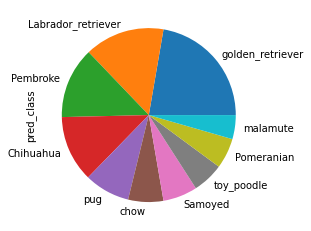

In [55]:
dog_preds['pred_class'].value_counts(sort=True)[0:10].plot.pie()

**Breed prediction distribution by number of favorites**

<AxesSubplot:ylabel='favorite_counts'>

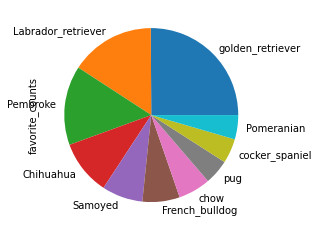

In [56]:
dog_preds.join(clean_enhanced_tweets_df['favorite_counts']).groupby(['pred_class']) \
    .sum().sort_values(by='favorite_counts', ascending=False)[0:10]['favorite_counts'].plot.pie()

---
---

## Predict breeds from images

After some research, including looking at the Udacity [Dog Identification App](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-dog-classification/dog_app.ipynb) (which unfortunately uses a different set of labels) we tracked down the dataset of dog breed labels that appear in the tweet images predictions dataset. It is the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/)!

### Background

In this section we will predict dog breeds for the various dog images extracted from tweets, and compare our results to those we downloaded and cleaned earlier. We will start with a pre-trained ImageNet classifier, trained on 1000 classes, and will then use transfer learning to train a new classifier for the 120 dog breeds present in the Stanford Dogs dataset, using the training images in that dataset.

Whilst we have no way to verify if out breed predictions are accurate, we can compare our top 3 predictions against the top 3 predictions downloaded earlier.

### Gather additional data

For convenience we will source the Stanford Dogs dataset from the Kaggle [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification/data) competition. Kaggle have already itemised the training images and labels as a CSV file, which we can easiliy load into a Pandas dataframe. Furthermore they provide an API to download the data assets, and a command line interface (CLI) to interact with this API from a Unix shell. We will now use `pip` to install the Kaggle tooling, and download the dataset.

In [57]:
image_net_data = './data/image-net-data'

In [58]:
!kaggle competitions download -c dog-breed-identification -p \$image_net_data

dog-breed-identification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [59]:
!(cd \$image_net_data;unzip -uo dog-breed-identification.zip)

Archive:  dog-breed-identification.zip


In [60]:
image_net_labels_df = pd.read_csv(image_net_data + '/labels.csv')

### Assess data coverage

Next we will verify that the dog breed labels in the Stanford Dogs dataset cover all the dog breed labels used in the tweet images breed prediction dataframe. For consistency, we first convert both sets of labels to lowercase, to get around anomalies in how some breed names get capitalised.

In [61]:
clean_predictions_df['pred_class'] = clean_predictions_df['pred_class'].str.lower()
image_net_labels_df['breed'] = image_net_labels_df['breed'].str.lower()

In [62]:
[predicted_breed for predicted_breed in clean_predictions_df[clean_predictions_df['pred_is_dog']]['pred_class'] 
 if not predicted_breed in list(image_net_labels_df['breed'])]

['dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian',
 'dalmatian']

The one missing label is 'dalmatian' which is not part of the Stanford Dogs set of breed labels (or the Kaggle set) and yet does appear in the original ImageNet dataset. 

So as to recognise images of Dalmations, we will need to fall back to the pretrained ImageNet classifier, the one covering 1000 classes. In any case, we need to do this to recognise images of objects other than dogs, and to be able to set the boolean flag that indicates the predicted class is not a dog breed.

### Validation

During training, the models will return predictions for the samples we give it. We then compare these predictions against the labels that are part of our training data, so as to measure the accuracy of the model, and generate a loss that is used to tune model weights and improve subsequent predictions.

Learning is an iterative process controlled by a number of parameters and hyper-parameters:

* data transformation: the model is shown transformed images (such as mirror images, small rotations or crops of the original image), in effect the model is trained on a broader set of images, which means it should generalise better
* model architecture: this includes the number of layers (how deep the model is), dimensions (the feature map size from the orginal image into subsequent layers, the number of channels or depth of each layer), layer parameters such as dropout probability, etc
* optimiser parameters such as learning rate (the extent to which loss influences weights)
* the number of epochs or iterations through the full training set, the expectation being that losses decrease (and prediction accuracy increases) in subsequent iterations

The most effective way to tune all the parameters is to validate the model at each iteration. This is done by running the model against samples it has not been trained against (i.e.: which it hasn't seen before) which is more representative of a real world use case, and then measuring prediction loss and accuracy.

### Data loading

Next we setup the Pytorch data loading classes required to load the training and validation data, with which to perform transfer learning on our modified model. Since the validation set also requires labelled data, and the Kaggle data only has label in the training dataset, we will need to split that into training and validation.

We will chose an 80/20 training/validation split. The easiest approach is to apply the splits to the ImageNet labels dataframe holding the image Ids and labels, and drive the rest of the data selection process from here. The split is performed once, and used across many iterations, such that the validation split is only used for validation (not training).

A naive approach is to take the first 80% of rows in the  dataframe, and use the remaining 20% for validation. But this would not be a good approach, as there is no guarantee that that 80/20 split would be reflected within each of our 120 classes. 

The scikit-learn library provides a stratified split functions that splits the dataset into K equal sized folds, and then preserves the class distribution between folds. By taking 5 folds, then using four for training and one for alidation, we get our 80/20 split.

In [63]:
from sklearn import model_selection

skf = model_selection.StratifiedKFold(n_splits=5)
train_idx, valid_idx = next(iter(skf.split(np.arange(len(image_net_labels_df.index)),
                                           image_net_labels_df['breed'])))
train_idx.shape, valid_idx.shape

((8177,), (2045,))

In [64]:
train_split_df = image_net_labels_df.iloc[train_idx]
valid_split_df = image_net_labels_df.iloc[valid_idx]
train_split_df.shape, valid_split_df.shape

((8177, 2), (2045, 2))

Next we create a dataset class that can read the image file from a URL (the tweet use case) or a local file (the ImageNet download case), and in both cases takes the labels from a data frame.

In [174]:
from PIL import Image, ImageFile, UnidentifiedImageError
import requests
from io import BytesIO


class ImageDataFrameDataset:
    
    def __init__(self, 
                 df,  
                 img_col,
                 lbl_col=None,
                 img_dir=None, 
                 transform=None):
        """
        Args:
            df: a dataframe holding class labels and, either an image Id, the image file, or an image URL
            img_col: column holding image file name (either the name without suffix, or the full URL)
            lbl_col: optional column holding image label
            img_dir: an optional directory in which to find the image files (unless remote)
            transfor: optional transform, or chain of transforms
        """
        self.df = df
        self.img_col = img_col
        self.lbl_col = lbl_col
        self.img_dir = img_dir
        self.transform = transform       

        if self.lbl_col is not None:
            self.classes, self.class_to_idx = self._find_classes(self.df[self.lbl_col])
            self.labels = [self.class_to_idx[getattr(row, self.lbl_col)] 
                           for row in self.df.itertuples()]
                
        if self.img_dir is None:
            self.session = requests.Session()

        self.samples = [self._read_image(getattr(row, self.img_col))
                        for row in self.df.itertuples()]

    def _read_image(self, resource):
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        
        if self.img_dir is not None:
            file_name = f'{self.img_dir}/{resource}.jpg'
            with open(file_name, 'rb') as fd:
                image = Image.open(fd)
                return image.convert('RGB')
        else:
            response = self.session.get(resource, stream=True)
            if response.status_code == 200:
                response.raw.decode_content = True
                try:
                    image = Image.open(response.raw)
                    return image.convert('RGB')
                except UnidentifiedImageError as ex:
                    print(f'Image open failed for URL {resource}, exception {ex}')
            return Image.new('RGB', (224, 224))
                    
    def _find_classes(self, series):
        classes = series.unique()
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        image = self.samples[index]
        if self.transform is not None:
            image = self.transform(image)
            
        if self.labels is not None:
            return image, self.labels[index]
        else:
            return image
        
    def __len__(self):
        return len(self.samples)

In [175]:
import os
from torchvision import datasets, transforms
from torch.utils import data
import torch

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

batch_size = 128
do_use_cuda = True

if do_use_cuda:
    compute_device = torch.device('cuda')
    do_pin_memory = True

else:
    compute_device = torch.device('cpu')
    do_pin_memory = False

training_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                         std=(0.229, 0.224, 0.225))
])

inference_transforms = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                         std=(0.229, 0.224, 0.225))
])

In [176]:
train_ds = ImageDataFrameDataset(train_split_df, 'id',
                                 lbl_col='breed',
                                 img_dir='./data/image-net-data/train',
                                 transform=training_transforms)

train_dl = data.DataLoader(train_ds,
                          batch_size=batch_size,
                          shuffle=True,
                          pin_memory=do_pin_memory)

valid_ds = ImageDataFrameDataset(valid_split_df, 'id',
                                 lbl_col='breed',
                                 img_dir='./data/image-net-data/train',
                                 transform=inference_transforms)

valid_dl = data.DataLoader(valid_ds,
                           batch_size=batch_size,
                           pin_memory=do_pin_memory)

In [177]:
%%time
test_ds = ImageDataFrameDataset(clean_img_preds_df, 'jpg_url',
                                transform=inference_transforms)

test_dl = data.DataLoader(test_ds,
                          batch_size=batch_size,
                          pin_memory=do_pin_memory)

CPU times: user 1min 7s, sys: 2.21 s, total: 1min 9s
Wall time: 1min 48s


In [153]:
data_loaders = {
    'train': train_dl,
    'valid': valid_dl,
    'test': test_dl
}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breeds.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [182]:
import torchvision.models as models
import torch.nn as nn

model_transfer = models.wide_resnet50_2(pretrained=True)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


In [183]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [184]:
# Get the number of dog breed classes in our training set

num_dog_breeds = len(train_ds.classes)
num_dog_breeds

120

In [185]:
num_final_layers = model_transfer.fc.in_features
num_final_layers

2048

In [186]:
def freeze_layer(layer, unfreeze=False):
    for param in layer.parameters():
        param.requires_grad = unfreeze

In [187]:
freeze_layer(model_transfer)

In [188]:
model_transfer.fc = nn.Sequential(
    nn.Linear(num_final_layers, num_dog_breeds),
    nn.LogSoftmax(dim=-1)
)

In [189]:
model_transfer = model_transfer.to(compute_device)

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [190]:
from torch import nn, optim

criterion_transfer = nn.NLLLoss()
# optimizer_transfer = optim.Adam([
#     {'params': model_transfer.layer3.parameters(), 'lr': 7e-5},
#     {'params': model_transfer.layer4.parameters(), 'lr': 5e-4},
#     {'params': model_transfer.fc.parameters(), 'lr': 3e-3}
# ])
optimizer_transfer = optim.Adam(params=model_transfer.parameters())

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [191]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np

def train(n_epochs, loaders, model, optimiser, criterion, compute_device, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs + 1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to compute device
            data, target = data.to(compute_device, non_blocking=True), target.to(compute_device, non_blocking=True)
                
            optimiser.zero_grad()

            output = model(data)
            loss = criterion(output, target)
            
            loss.backward()
            optimiser.step()        
            
            train_loss = train_loss + ((loss.item() - train_loss) / (batch_idx + 1))
            
            del data
            del target

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to compute device
            data, target = data.to(compute_device, non_blocking=True), target.to(compute_device, non_blocking=True)
               
            output = model(data)
            loss = criterion(output, target)
            
            valid_loss = valid_loss + ((loss.item() - valid_loss) / (batch_idx + 1))
            
            if loss < valid_loss_min:
                torch.save(model.state_dict(), 'model_transfer.pt')
                valid_loss_min = valid_loss
            
            del data
            del target
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
            
    # return trained model
    return model

Train the fully connected layer for the new number of classes (i.e.: number of dog breeds, as opposed to ImageNet classes).

In [ ]:
NUM_EPOCHS = 7

# train the model
model_transfer = train(NUM_EPOCHS, 
                       data_loaders, 
                       model_transfer, 
                       optimizer_transfer, 
                       criterion_transfer, 
                       compute_device, 
                       'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.316281 	Validation Loss: 1.528238
Epoch: 2 	Training Loss: 1.654156 	Validation Loss: 0.777113


Unfreeze the last layer, and train some more.

In [165]:
freeze_layer(model_transfer.layer4, unfreeze=True)

In [166]:
NUM_EPOCHS = 5

# train the model
model_transfer = train(NUM_EPOCHS, 
                       data_loaders, 
                       model_transfer, 
                       optimizer_transfer, 
                       criterion_transfer, 
                       compute_device, 
                       'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 1.563123 	Validation Loss: 1.272635
Epoch: 2 	Training Loss: 1.335727 	Validation Loss: 1.294836
Epoch: 3 	Training Loss: 1.238240 	Validation Loss: 1.250127
Epoch: 4 	Training Loss: 1.086193 	Validation Loss: 1.190099
Epoch: 5 	Training Loss: 1.041907 	Validation Loss: 1.185872


<All keys matched successfully>

Unfreeze the penultimate layer, and train some more.

In [168]:
freeze_layer(model_transfer.layer3, unfreeze=True)

In [169]:
NUM_EPOCHS = 5

# train the model
model_transfer = train(NUM_EPOCHS, 
                       data_loaders, 
                       model_transfer, 
                       optimizer_transfer, 
                       criterion_transfer, 
                       compute_device, 
                       'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.985819 	Validation Loss: 1.405653
Epoch: 2 	Training Loss: 0.929377 	Validation Loss: 1.390401
Epoch: 3 	Training Loss: 0.854332 	Validation Loss: 1.178199
Epoch: 4 	Training Loss: 0.842138 	Validation Loss: 1.309852
Epoch: 5 	Training Loss: 0.841108 	Validation Loss: 1.479190


<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    return None

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

In [ ]:
clean_predictions_df.info()

In [ ]:
sorted(clean_predictions_df.loc[clean_predictions_df.pred_is_dog].pred_class.unique().to_numpy())

### Generate internal report

Having cleaned the data, and generated data insights, we can now generate the internal documentation from this notebook's markdown cells.

(you probably want to clear all output previous to the data insights output generated in the last section, and then SAVE the notebook)

In [ ]:
# !jupyter nbconvert --no-input --to pdf wrangle_act.ipynb
# !mv wrangle_act.pdf wrangle_report.pdf